# Stock Predictor RNN 

In this project, I perform a time series prediction using a Recurrent Neural Network regressor. For this example, I will predict Apple's stock price 7 days in advance.

The particular network architecture I will employ for my RNN is a  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.

## Step 1: Loading the data

First let's load in our time series - a history of around 140 days of Apple's stock price. Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
data = pd.read_csv('C:/Users/yangx/Desktop/laioffer/project/DL/HW3/stock-prediction-lstm-using-keras-master/data/sandp500/all_stocks_5yr.csv')
cl = data[data['Name']=='AAPL'].close.values

In [3]:
cl.shape

(1259,)

In [4]:
scl = MinMaxScaler()
#Scale the data
cl = cl.reshape(cl.shape[0],1)
cl = scl.fit_transform(cl)
cl

array([[0.0977103 ],
       [0.103438  ],
       [0.08951884],
       ...,
       [0.81558288],
       [0.86855117],
       [0.84028522]])

## Step 2:  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="images/timeseries_windowing_training.gif" width=600 height=600/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now let's window the input time series as described above!  

In [5]:
#Create a function to process the data into 7 day look back slices
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)
X,y = processData(cl,7)


## Step 3: Split training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how we would predict *future* values of a time series.

In [6]:
X_train,X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train,y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

1000
251
1000
251


## Step 4:  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used

In [7]:
#Build the model
model = Sequential()
model.add(LSTM(64,input_shape=(7,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)

Train on 1000 samples, validate on 251 samples
Epoch 1/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0038 - val_loss: 0.0534
Epoch 2/300
1000/1000 [==============================] - 0s 186us/step - loss: 0.0054 - val_loss: 0.0064
Epoch 3/300
1000/1000 [==============================] - 0s 158us/step - loss: 0.0030 - val_loss: 0.0027
Epoch 4/300
1000/1000 [==============================] - 0s 160us/step - loss: 0.0013 - val_loss: 0.0019
Epoch 5/300
1000/1000 [==============================] - 0s 155us/step - loss: 6.0497e-04 - val_loss: 9.7606e-04
Epoch 6/300
1000/1000 [==============================] - 0s 156us/step - loss: 4.7417e-04 - val_loss: 7.8979e-04
Epoch 7/300
1000/1000 [==============================] - 0s 179us/step - loss: 5.7942e-04 - val_loss: 0.0024
Epoch 8/300
1000/1000 [==============================] - 0s 154us/step - loss: 5.9602e-04 - val_loss: 0.0025
Epoch 9/300
1000/1000 [==============================] - 0s 158us/step - loss: 5.4945e-04 -

Epoch 74/300
1000/1000 [==============================] - 0s 188us/step - loss: 2.7072e-04 - val_loss: 5.7274e-04
Epoch 75/300
1000/1000 [==============================] - 0s 194us/step - loss: 2.9754e-04 - val_loss: 6.5956e-04
Epoch 76/300
1000/1000 [==============================] - 0s 170us/step - loss: 2.6974e-04 - val_loss: 5.6124e-04
Epoch 77/300
1000/1000 [==============================] - 0s 195us/step - loss: 3.0389e-04 - val_loss: 6.3892e-04
Epoch 78/300
1000/1000 [==============================] - 0s 196us/step - loss: 2.7102e-04 - val_loss: 5.4630e-04
Epoch 79/300
1000/1000 [==============================] - 0s 145us/step - loss: 3.1533e-04 - val_loss: 6.1821e-04
Epoch 80/300
1000/1000 [==============================] - 0s 194us/step - loss: 2.7417e-04 - val_loss: 5.2009e-04
Epoch 81/300
1000/1000 [==============================] - 0s 170us/step - loss: 3.3205e-04 - val_loss: 5.9792e-04
Epoch 82/300
1000/1000 [==============================] - 0s 199us/step - loss: 2.7741e-

1000/1000 [==============================] - 0s 169us/step - loss: 1.9118e-04 - val_loss: 3.3471e-04
Epoch 146/300
1000/1000 [==============================] - 0s 155us/step - loss: 1.7334e-04 - val_loss: 3.4645e-04
Epoch 147/300
1000/1000 [==============================] - 0s 153us/step - loss: 1.8751e-04 - val_loss: 3.3075e-04
Epoch 148/300
1000/1000 [==============================] - 0s 159us/step - loss: 1.7157e-04 - val_loss: 3.4818e-04
Epoch 149/300
1000/1000 [==============================] - 0s 158us/step - loss: 1.8397e-04 - val_loss: 3.2769e-04
Epoch 150/300
1000/1000 [==============================] - 0s 150us/step - loss: 1.6992e-04 - val_loss: 3.5049e-04
Epoch 151/300
1000/1000 [==============================] - 0s 154us/step - loss: 1.8056e-04 - val_loss: 3.2582e-04
Epoch 152/300
1000/1000 [==============================] - 0s 165us/step - loss: 1.6834e-04 - val_loss: 3.5333e-04
Epoch 153/300
1000/1000 [==============================] - 0s 180us/step - loss: 1.7727e-04 - 

1000/1000 [==============================] - 0s 170us/step - loss: 1.9659e-04 - val_loss: 7.3434e-04
Epoch 217/300
1000/1000 [==============================] - 0s 189us/step - loss: 1.9917e-04 - val_loss: 6.2595e-04
Epoch 218/300
1000/1000 [==============================] - 0s 157us/step - loss: 2.0877e-04 - val_loss: 5.0592e-04
Epoch 219/300
1000/1000 [==============================] - 0s 147us/step - loss: 2.1283e-04 - val_loss: 4.1023e-04
Epoch 220/300
1000/1000 [==============================] - 0s 191us/step - loss: 2.1952e-04 - val_loss: 3.3019e-04
Epoch 221/300
1000/1000 [==============================] - 0s 161us/step - loss: 2.3026e-04 - val_loss: 2.8159e-04
Epoch 222/300
1000/1000 [==============================] - 0s 150us/step - loss: 2.4016e-04 - val_loss: 2.5656e-04
Epoch 223/300
1000/1000 [==============================] - 0s 153us/step - loss: 2.4482e-04 - val_loss: 2.4915e-04
Epoch 224/300
1000/1000 [==============================] - 0s 165us/step - loss: 2.3250e-04 - 

1000/1000 [==============================] - 0s 156us/step - loss: 2.0643e-04 - val_loss: 3.8245e-04
Epoch 288/300
1000/1000 [==============================] - 0s 156us/step - loss: 2.0372e-04 - val_loss: 3.3523e-04
Epoch 289/300
1000/1000 [==============================] - 0s 141us/step - loss: 2.1378e-04 - val_loss: 2.9805e-04
Epoch 290/300
1000/1000 [==============================] - 0s 156us/step - loss: 2.0250e-04 - val_loss: 2.8603e-04
Epoch 291/300
1000/1000 [==============================] - 0s 176us/step - loss: 2.0140e-04 - val_loss: 2.8133e-04
Epoch 292/300
1000/1000 [==============================] - 0s 141us/step - loss: 1.8000e-04 - val_loss: 2.8616e-04
Epoch 293/300
1000/1000 [==============================] - 0s 155us/step - loss: 1.6664e-04 - val_loss: 3.0949e-04
Epoch 294/300
1000/1000 [==============================] - 0s 156us/step - loss: 1.5078e-04 - val_loss: 3.6435e-04
Epoch 295/300
1000/1000 [==============================] - 0s 141us/step - loss: 1.5063e-04 - 

## Step 5: Checking model performance

With our model fit we can now make predictions on both our training and testing sets.

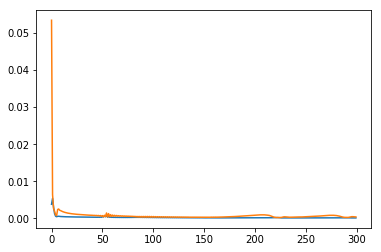

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [9]:
X_test[0]

array([[0.53324732],
       [0.53097957],
       [0.5909131 ],
       [0.5891313 ],
       [0.59358582],
       [0.60338576],
       [0.61342868]])

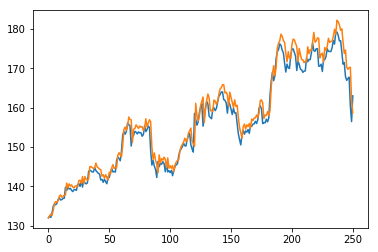

In [10]:
Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scl.inverse_transform(Xt))

In [11]:
act = []
pred = []
#for i in range(250):
i=249
Xt = model.predict(X_test[i].reshape(1,7,1))
print('predicted:{0}, actual:{1}'.format(scl.inverse_transform(Xt),scl.inverse_transform(y_test[i].reshape(-1,1))))
pred.append(scl.inverse_transform(Xt))
act.append(scl.inverse_transform(y_test[i].reshape(-1,1)))

predicted:[[161.94382]], actual:[[156.49]]


In [12]:
result_df = pd.DataFrame({'pred':list(np.reshape(pred, (-1))),'act':list(np.reshape(act, (-1)))})

In [13]:
#result_df.plot(kind='line')

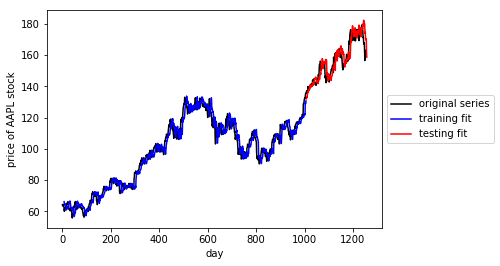

In [13]:
# plot original data
plt.plot(scl.inverse_transform(y.reshape(-1,1)), color='k')

Xtrain = model.predict(X_train)
Xtest = model.predict(X_test)

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X.shape[0]*0.80) + 7 # window_size
plt.plot(np.arange(7,split_pt,1), scl.inverse_transform(Xtrain), color='b')
plt.plot(np.arange(split_pt,split_pt+len(Xtest),1), scl.inverse_transform(Xtest), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of AAPL stock')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [14]:
X_test[249]

array([[0.93399212],
       [0.93723177],
       [0.90847987],
       [0.90046173],
       [0.90418733],
       [0.90702202],
       [0.84806038]])

In [16]:
# from the plot above we can see that the testing fit is already very near to real result.